In [2]:
from silence_tensorflow import silence_tensorflow

silence_tensorflow()

# Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import shutil
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import plot_model
from keras.utils import image_dataset_from_directory
import visualkeras
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import datetime
import PIL.Image
from keras.callbacks import LambdaCallback
from tqdm import tqdm
import tensorflow as tf
from datasets import *
import evaluate
from transformers import AutoImageProcessor
from transformers import TFAutoModelForImageClassification
from transformers import DefaultDataCollator
from transformers import create_optimizer
from xgboost import XGBClassifier
import keras_tuner
from sklearn.preprocessing import StandardScaler

/Users/dimronto/anaconda3/envs/GPUenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read data and basic preprocess

In [4]:
data = pd.read_csv("data/labeled.csv")
data.head()

ID damage                                      filename
0  ID_UBHORS     WD  d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg
1  ID_9DSOLZ      G  9ea16180c50d0cd539897eefbfe585314e50a56b.jpg
2  ID_JHLM0G      G  b6b564844041bc68774a553eaf43d61654657dd9.jpg
3  ID_ATREIJ     DR  62262859f0cd411aaf484082ed3ef0b625bc452a.jpg
4  ID_L2GAD6      G  03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg

# Split images and labels

In [5]:
X = data.copy()
X = data.drop_duplicates(subset="filename", keep="first")
X["target"] = X["damage"]
y = X["target"]
X = X.drop(columns=["damage", "target"])
X.head()

ID                                      filename
0  ID_UBHORS  d036341be8d6cd59851cb80bcc9a70cc9fbdba30.jpg
1  ID_9DSOLZ  9ea16180c50d0cd539897eefbfe585314e50a56b.jpg
2  ID_JHLM0G  b6b564844041bc68774a553eaf43d61654657dd9.jpg
3  ID_ATREIJ  62262859f0cd411aaf484082ed3ef0b625bc452a.jpg
4  ID_L2GAD6  03b6e2a8ace7cb611eccba289f3c83d9bd497584.jpg

# Examine Data and Preprocess

In [6]:
print(f"We have a total of {X.shape[0]} images")

We have a total of 26068 images


In [7]:
def get_image_dimensions(filename):
    with open(f"data/labeled/{filename}", "rb") as img_file:
        img = PIL.Image.open(img_file)
        width, height = img.size
    return width, height

In [8]:
stats = pd.DataFrame()
stats[["width", "height"]] = pd.DataFrame(
    X["filename"].apply(get_image_dimensions).tolist(), index=X.index
)
stats["aspect_ratio"] = stats["height"] / stats["width"]
stats.head()

width  height  aspect_ratio
0    640     480          0.75
1    320     240          0.75
2    640     480          0.75
3    640     480          0.75
4    320     240          0.75

In [9]:
stats.describe()

width        height  aspect_ratio
count  26068.000000  26068.000000  26068.000000
mean    1037.748350    724.604534      0.743655
std     1154.785546    754.121965      0.095588
min      117.000000    102.000000      0.450000
25%      320.000000    260.000000      0.750000
50%      640.000000    480.000000      0.750000
75%      640.000000    480.000000      0.750000
max     4608.000000   4160.000000      2.222222

In [10]:
print(
    f"Out of {X.shape[0]} images, {stats[stats['aspect_ratio'] == 0.75].shape[0]} have ascpect ratio 0.75"
)

Out of 26068 images, 24069 have ascpect ratio 0.75


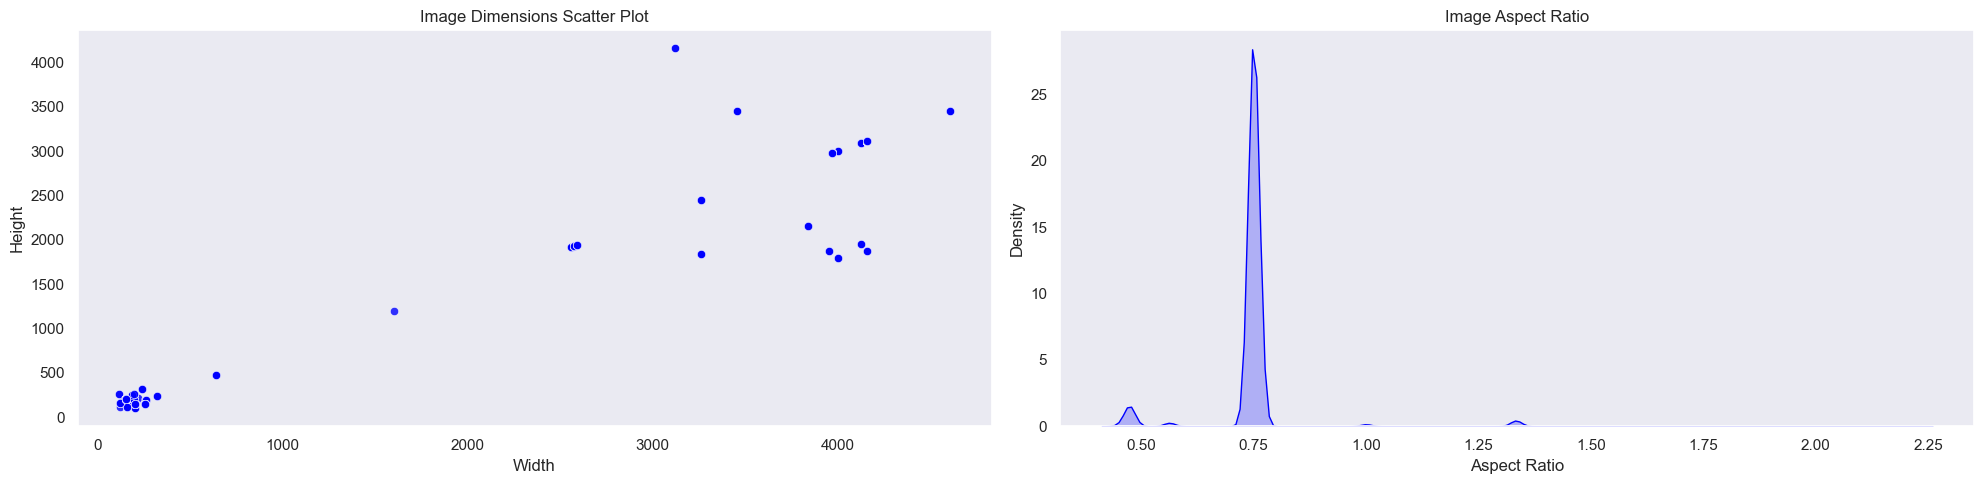

In [11]:
sns.set_theme(style="dark")

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(x="width", y="height", data=stats, alpha=0.8, ax=axes[0], color="blue")
axes[0].set_title("Image Dimensions Scatter Plot")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Height")

sns.kdeplot(stats["aspect_ratio"], fill=True, color="blue", ax=axes[1])
axes[1].set_title("Image Aspect Ratio")
axes[1].set_xlabel("Aspect Ratio")
axes[1].set_ylabel("Density")
plt.tight_layout()
plt.show()

In [12]:
filter = stats["aspect_ratio"] == 0.75

stats_ = stats[filter].copy()
X_ = X[filter].copy()
y_ = y[filter].copy()

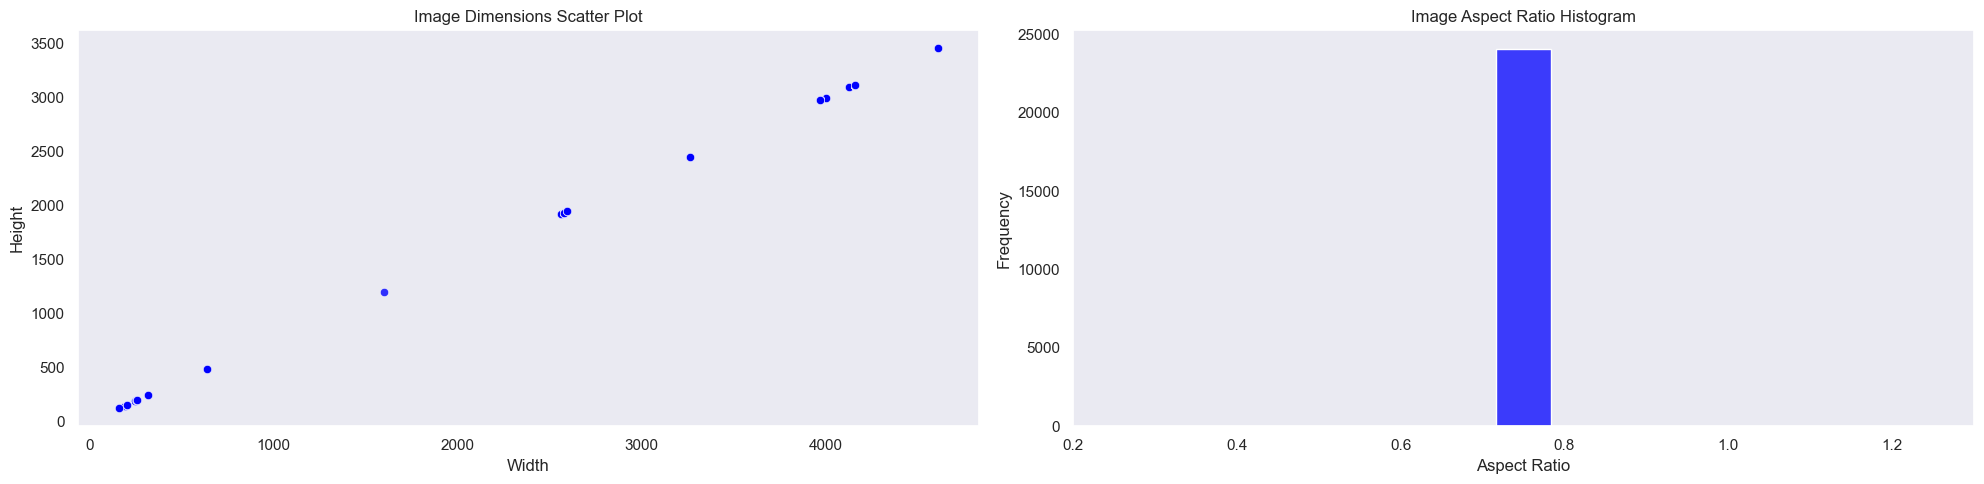

In [13]:
sns.set_theme(style="dark")

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.scatterplot(x="width", y="height", data=stats_, alpha=0.8, ax=axes[0], color="blue")
axes[0].set_title("Image Dimensions Scatter Plot")
axes[0].set_xlabel("Width")
axes[0].set_ylabel("Height")

sns.histplot(stats_["aspect_ratio"], bins=15, color="blue", kde=False, ax=axes[1])
axes[1].set_title("Image Aspect Ratio Histogram")
axes[1].set_xlabel("Aspect Ratio")
axes[1].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

In [14]:
stats_.describe()

width        height  aspect_ratio
count  24069.000000  24069.000000      24069.00
mean     870.843492    653.132619          0.75
std      933.538523    700.153892          0.00
min      160.000000    120.000000          0.75
25%      320.000000    240.000000          0.75
50%      640.000000    480.000000          0.75
75%      640.000000    480.000000          0.75
max     4608.000000   3456.000000          0.75

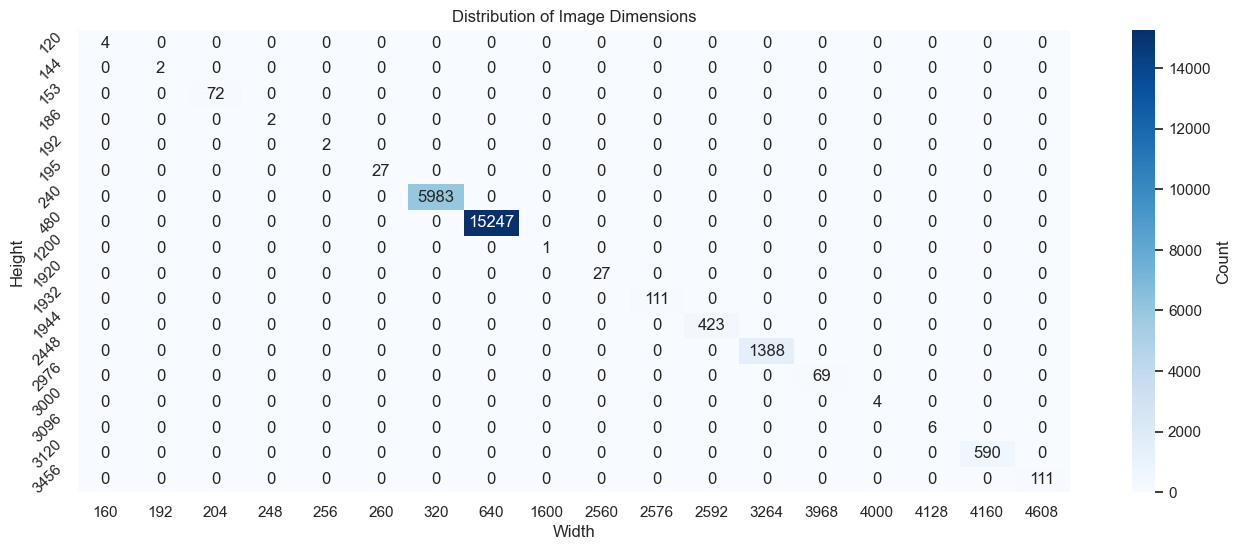

In [15]:
dimension_counts_pivot = stats_.pivot_table(
    index="height", columns="width", aggfunc="size", fill_value=0
)

# Create a heatmap with rotated y-axis labels
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(
    dimension_counts_pivot,
    cmap="Blues",
    annot=True,
    fmt="d",
    cbar_kws={"label": "Count"},
)
heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=0
)  # Adjust the rotation angle if needed
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45)  # Rotate y-axis labels
plt.title("Distribution of Image Dimensions")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [16]:
condition = (stats["width"] == 640) & (stats["height"] == 480)
percentage = (stats[condition].shape[0] / stats.shape[0]) * 100

print(f"{percentage:.2f}% of images have size (480, 640)")

58.49% of images have size (480, 640)


In [17]:
y.value_counts().sort_index()

target
DR        4516
G        11623
ND         272
WD        9238
other      419
Name: count, dtype: int64

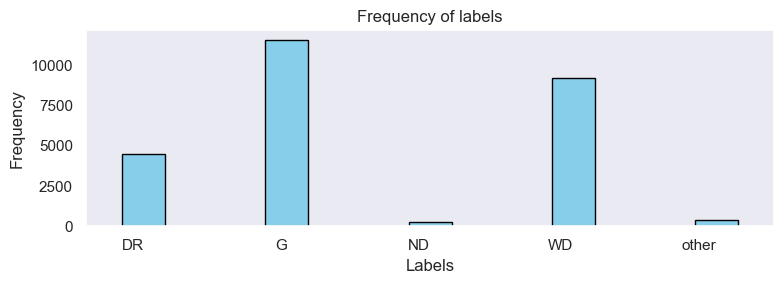

In [18]:
plt.figure(figsize=(8, 3))
y.value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", width=0.3
)
plt.title("Frequency of labels")
plt.xlabel("Labels")
plt.xticks(rotation=0, ha="right")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Split data: train, val, test (80%, 10%, 10%)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=13
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.5, stratify=y_test, random_state=13
)

In [20]:
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (20854, 2)
Validation shape: (2607, 2)
Test shape: (2607, 2)


In [21]:
train = pd.concat([X_train, y_train], axis=1)
val = pd.concat([X_val, y_val], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Useful functions - Epoch plotting, Confusion Matrix

In [22]:
def plot_epochs(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
def plot_confusion_matrix(model, test_dataset, true_labels):
    y_pred = model.predict(test_dataset)

    y_pred_classes = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(true_labels, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_mat,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=test_dataset.class_names,
        yticklabels=test_dataset.class_names,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Check proportions

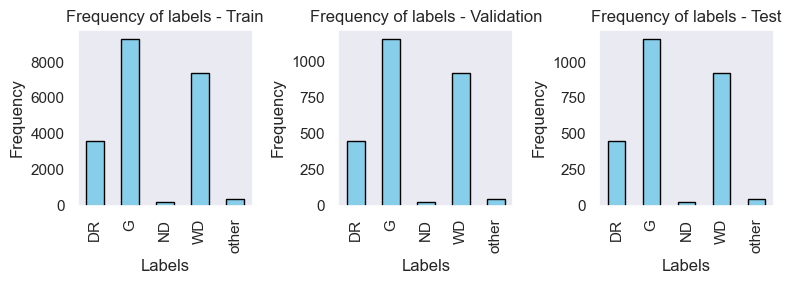

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

train["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[0]
)
axes[0].set_title("Frequency of labels - Train")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Frequency")

val["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[1]
)
axes[1].set_title("Frequency of labels - Validation")
axes[1].set_xlabel("Labels")
axes[1].set_ylabel("Frequency")

test["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[2]
)
axes[2].set_title("Frequency of labels - Test")
axes[2].set_xlabel("Labels")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Organize folders with each category

In [25]:
def organize_data_to_folders(data, source_dir, dest_dir):
    for _, (_, filename, target) in data.iterrows():
        destination = f"{dest_dir}/{target}"
        source = f"{source_dir}/{filename}"
        shutil.copy(source, destination)

In [26]:
RUN_COPY = False

if RUN_COPY:
    organize_data_to_folders(train, "data/labeled", "organized-data/train")
    organize_data_to_folders(val, "data/labeled", "organized-data/validation")
    organize_data_to_folders(test, "data/labeled", "organized-data/test")

In [27]:
def dataset_from_directory(height, width, batch_size, oversample=None):
    image_size = (height, width)
    batch_size = batch_size

    if oversample == None:
        train_directory = "organized-data/train/"
    else:
        train_directory = "organized-data/oversampled_train/"

    train_dataset = image_dataset_from_directory(
        directory=train_directory,
        labels="inferred",
        label_mode="categorical",
        image_size=image_size,
        shuffle=True,
        seed=13,
        batch_size=batch_size,
    )

    val_dataset = image_dataset_from_directory(
        directory="organized-data/validation/",
        labels="inferred",
        label_mode="categorical",
        image_size=image_size,
        shuffle=False,
        seed=13,
        batch_size=batch_size,
    )

    test_dataset = image_dataset_from_directory(
        directory="organized-data/test/",
        labels="inferred",
        label_mode="categorical",
        image_size=image_size,
        shuffle=False,
        seed=13,
        batch_size=batch_size,
    )

    return train_dataset, val_dataset, test_dataset

In [28]:
height, width = 224, 224
batch_size = 32

train_dataset, val_dataset, test_dataset = dataset_from_directory(
    height, width, batch_size
)

Found 20854 files belonging to 5 classes.
Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Found 2607 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.


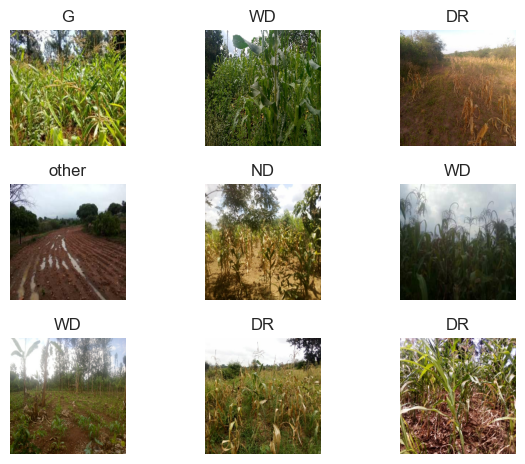

In [29]:
plt.figure(figsize=(6.4, 4.8))
for images, labels in train_dataset.take(10):
    cnt = 0
    uniq = []
    for i in range(len(images)):
        label = train_dataset.class_names[np.argmax(labels[i].numpy())]
        if label in uniq and cnt < 5:
            continue
        uniq.append(label)
        ax = plt.subplot(3, 3, cnt + 1)
        cnt += 1
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{label}")
        plt.axis("off")
        if cnt == 9:
            break
plt.tight_layout()
plt.show()

# Building a random classifier - majority classifier

In [30]:
num_classes = len(test_dataset.class_names)
np.random.seed(13)

class_weights = train["target"].value_counts().values
class_probabilities = class_weights / np.sum(class_weights)
random_predictions = np.random.choice(
    range(num_classes), size=test.shape[0], p=class_probabilities
)
random_predictions

array([1, 0, 2, ..., 2, 1, 1])

In [31]:
true_labels = np.array(
    [np.argmax(label) for _, labels in test_dataset for label in labels]
)
true_labels

array([0, 0, 0, ..., 4, 4, 4])

In [32]:
accuracy = accuracy_score(true_labels, random_predictions)
print("Random Classifier Accuracy:", round(accuracy, 4))

Random Classifier Accuracy: 0.252


In [33]:
accuracy = accuracy_score(true_labels, np.ones(true_labels.shape[0]))
print("Majority Classifier Accuracy:", round(accuracy, 4))

Majority Classifier Accuracy: 0.4461


# Transform each image to 1D numpy array

In [33]:
height, width = 150, 150
batch_size = 32

train_dataset, val_dataset, test_dataset = dataset_from_directory(
    height, width, batch_size
)

Found 20854 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.


In [ ]:
images = []
labels = []

for image, label in tqdm(train_dataset.as_numpy_iterator(), total=len(train_dataset)):
    images.append(image)
    labels.append(label)

In [ ]:
train_images = np.vstack(images)
train_images = np.divide(np.reshape(
    train_images, (train_images.shape[0], -1)), 255.0)

train_labels = np.vstack(labels)
train_labels = np.argmax(train_labels, axis=1)

In [ ]:
images = []
labels = []

for image, label in tqdm(test_dataset.as_numpy_iterator(), total=len(test_dataset)):
    images.append(image)
    labels.append(label)

  0%|          | 0/82 [00:00<?, ?it/s]

100%|██████████| 82/82 [00:07<00:00, 11.45it/s]


In [ ]:
test_images = np.vstack(images)
test_images = np.divide(np.reshape(
    test_images, (test_images.shape[0], -1)), 255.0)

test_labels = np.vstack(labels)
test_labels = np.argmax(test_labels, axis=1)

In [ ]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(train_images)

In [ ]:
id2label_ = {"DR": 0, "G": 1, "ND": 2, "WD": 3, "other": 4}

# Logistic Regression

In [40]:
from sklearn.linear_model import LogisticRegression


clf = LogisticRegression(random_state=13, solver="saga", max_iter=200).fit(
    train_images_scaled, train_labels
)

/Users/dimronto/anaconda3/envs/GPUenv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.42117376294591485


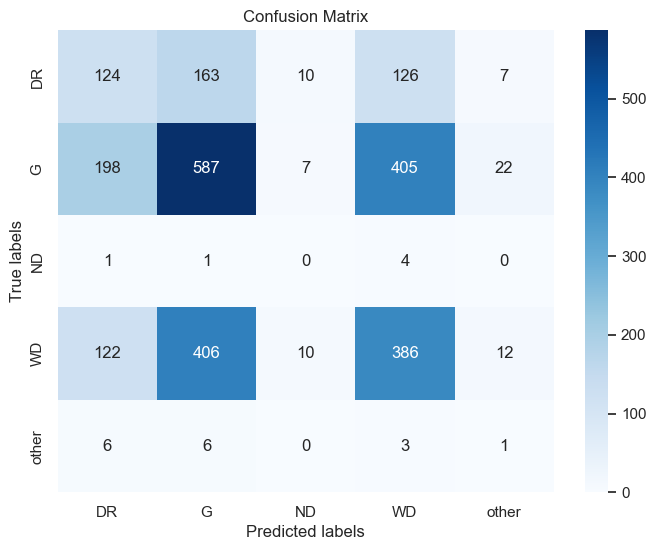

In [41]:
y_pred = clf.predict(scaler.transform(test_images))
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_pred, test_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=id2label_.keys(),
    yticklabels=id2label_.keys(),
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

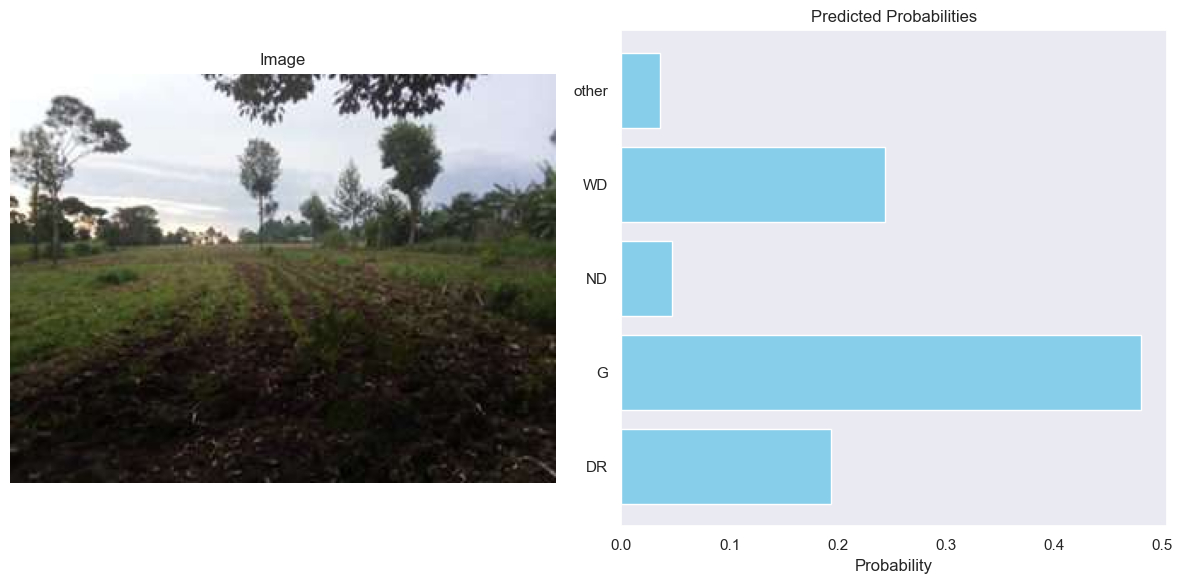

In [42]:
image_path = f"data/labeled/{test['filename'].iloc[0]}"
image = PIL.Image.open(image_path)

probabilities = clf.predict_proba([test_images[0]])
class_labels = list(id2label_.keys())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].barh(y=np.arange(len(class_labels)),
             width=probabilities[0], color="skyblue")
axes[1].set_yticks(np.arange(len(class_labels)))
axes[1].set_yticklabels(class_labels)
axes[1].set_xlabel("Probability")
axes[1].set_title("Predicted Probabilities")

plt.tight_layout()
plt.show()

# Random Forest Classifier

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=13, n_jobs=-1)
rf_classifier.fit(train_images_scaled, train_labels)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=13)

Accuracy: 0.47410817031070196


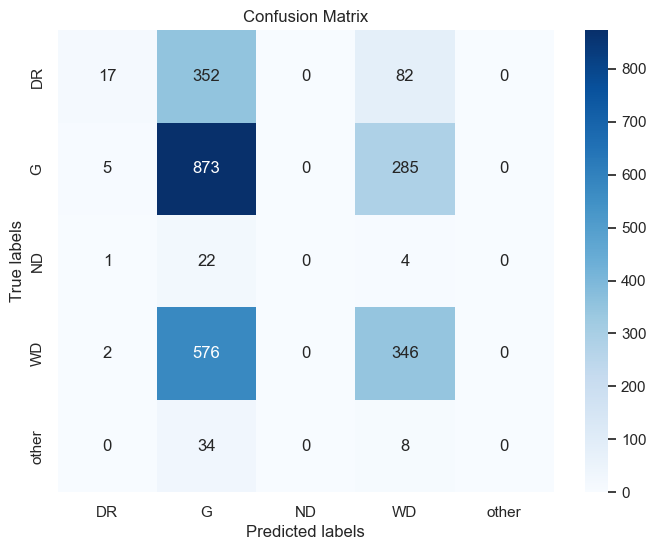

In [44]:
y_pred = rf_classifier.predict(scaler.transform(test_images))
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=id2label_.keys(),
    yticklabels=id2label_.keys(),
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

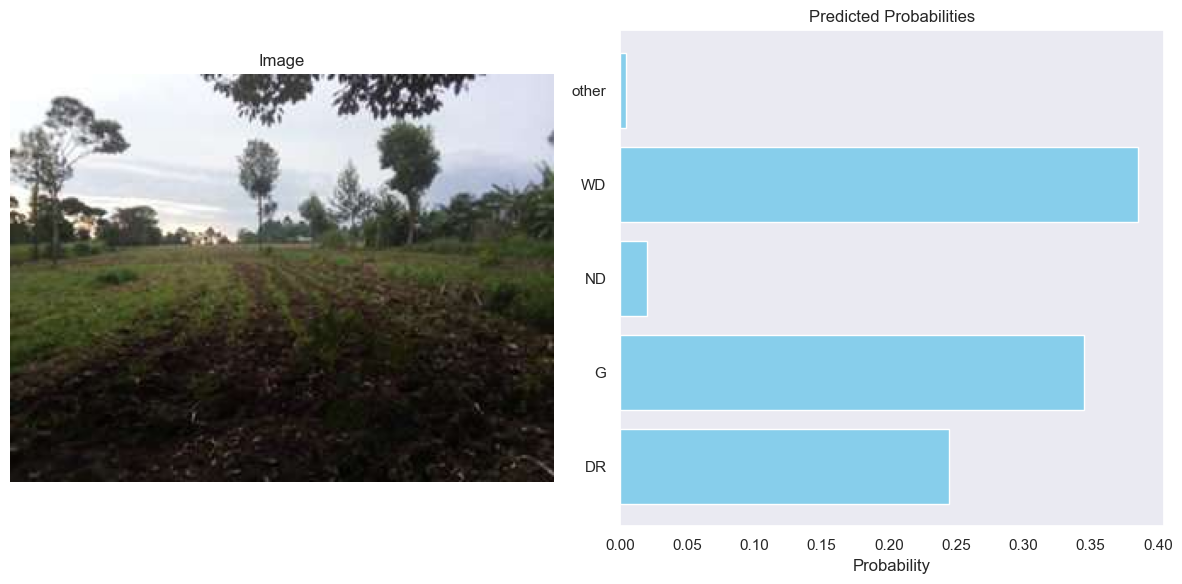

In [45]:
image_path = f"data/labeled/{test['filename'].iloc[0]}"
image = PIL.Image.open(image_path)

probabilities = rf_classifier.predict_proba([test_images[0]])
class_labels = list(id2label_.keys())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].barh(y=np.arange(len(class_labels)),
             width=probabilities[0], color="skyblue")
axes[1].set_yticks(np.arange(len(class_labels)))
axes[1].set_yticklabels(class_labels)
axes[1].set_xlabel("Probability")
axes[1].set_title("Predicted Probabilities")

plt.tight_layout()
plt.show()

# Support Vector Machines

In [46]:
from sklearn import svm

svmcf = svm.SVC()
svmcf.fit(train_images_scaled, train_labels)

SVC()

Accuracy: 0.5097813578826237


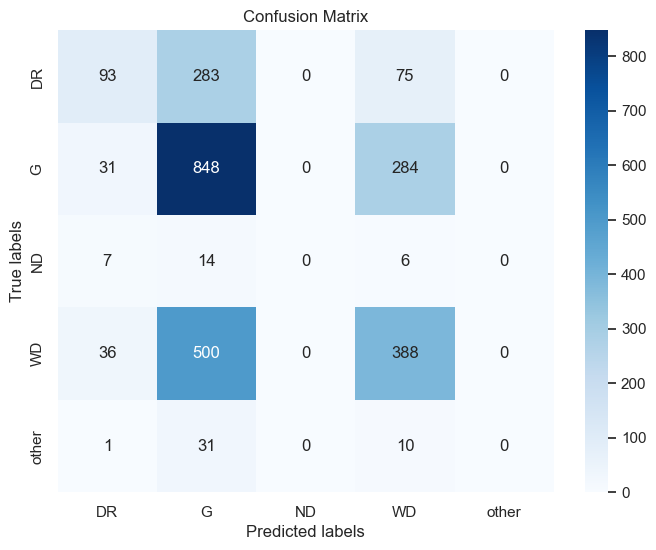

In [47]:
y_pred = svmcf.predict(scaler.transform(test_images))
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=id2label_.keys(),
    yticklabels=id2label_.keys(),
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# K - Neighbors Classifier

100%|██████████| 25/25 [13:09<00:00, 31.57s/it]


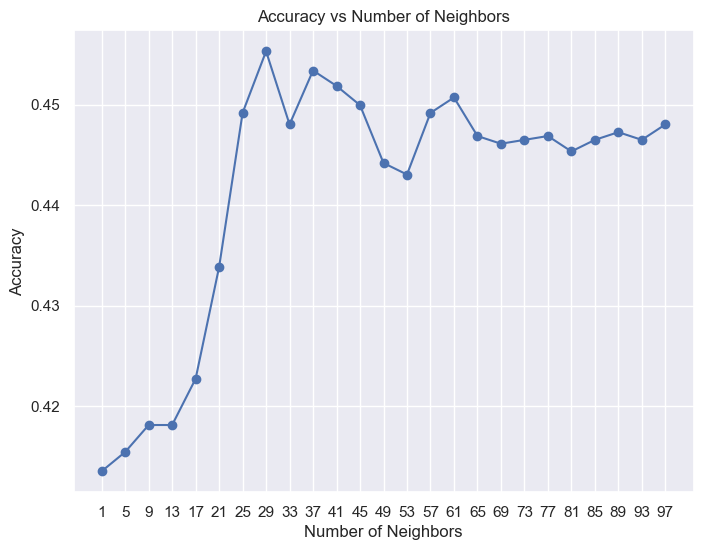

In [40]:
from sklearn.neighbors import KNeighborsClassifier

neighbors = np.arange(1, 101, 4)
accuracies = []

for n in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)

    knn.fit(train_images_scaled, train_labels)
    y_pred = knn.predict(scaler.transform(test_images))

    accuracy = accuracy_score(test_labels, y_pred)
    accuracies.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(neighbors, accuracies, marker="o", linestyle="-")
plt.title("Accuracy vs Number of Neighbors")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.xticks(neighbors)
plt.grid(True)
plt.show()

In [43]:
k = np.argmax(accuracies)
accuracies[k]

0.4553126198695819

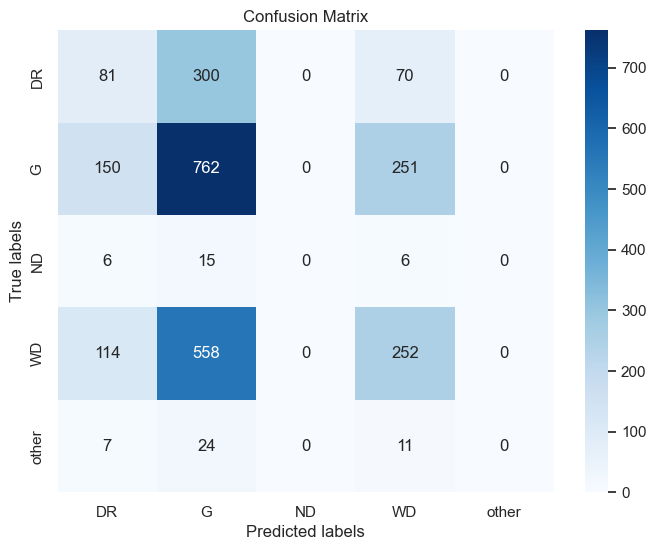

In [42]:
conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=id2label_.keys(),
    yticklabels=id2label_.keys(),
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Gradient Boosted Trees

In [43]:
from xgboost import XGBClassifier

bst = XGBClassifier()
bst.fit(train_images_scaled, train_labels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.5067126965861143


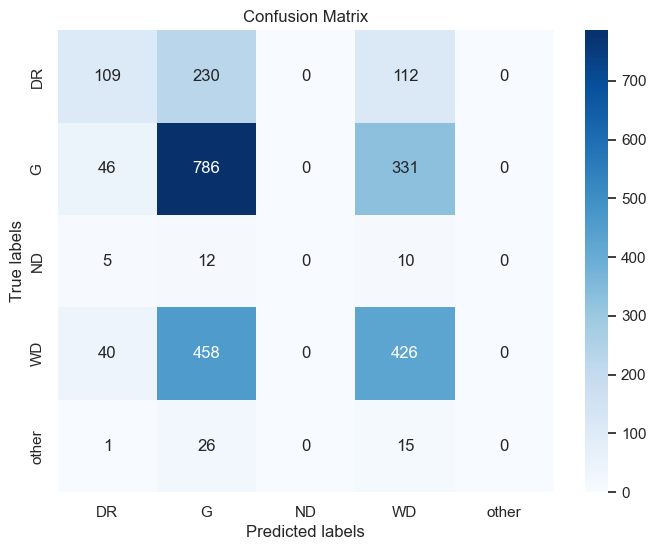

In [44]:
y_pred = bst.predict(scaler.transform(test_images))
accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=id2label_.keys(),
    yticklabels=id2label_.keys(),
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

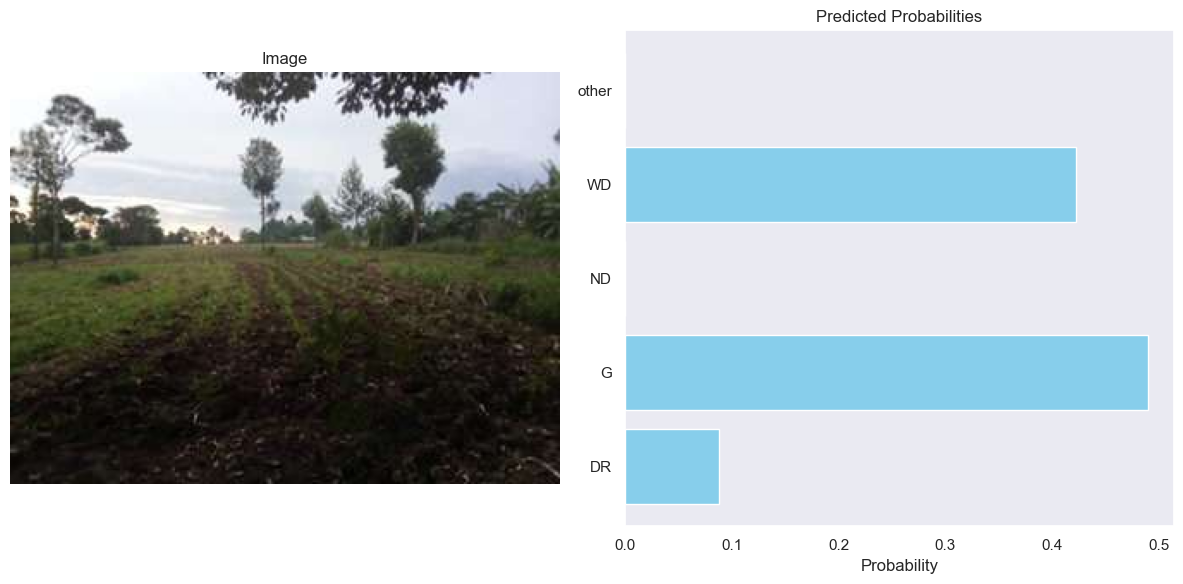

In [46]:
image_path = f"data/labeled/{test['filename'].iloc[0]}"
image = PIL.Image.open(image_path)

probabilities = bst.predict_proba([test_images[0]])
class_labels = list(id2label_.keys())
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image)
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].barh(y=np.arange(len(class_labels)),
             width=probabilities[0], color="skyblue")
axes[1].set_yticks(np.arange(len(class_labels)))
axes[1].set_yticklabels(class_labels)
axes[1].set_xlabel("Probability")
axes[1].set_title("Predicted Probabilities")

plt.tight_layout()
plt.show()

# Building a simple Neural Netwrok model

In [ ]:
height, width = 224, 224
batch_size = 32

train_dataset, val_dataset, test_dataset = dataset_from_directory(
    height, width, batch_size
)

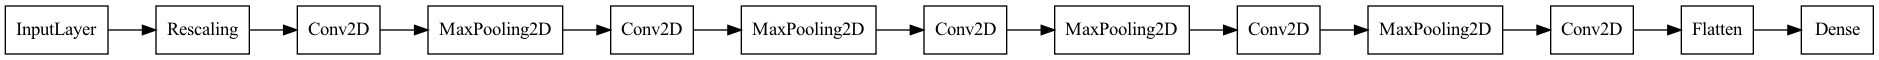

In [50]:
inputs = keras.Input(shape=(height, width, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
plot_model(
    model,
    to_file="models/base_model.png",
    show_shapes=False,
    show_layer_names=False,
    rankdir="LR",
)

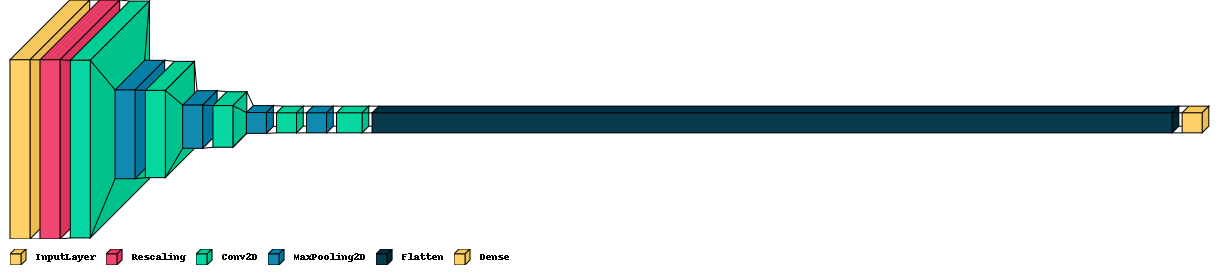

In [39]:
visualkeras.layered_view(model, legend=True, scale_xy=0.8, max_z=800)

In [44]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/base_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    tensorboard_callback,
]

In [45]:
history = model.fit(
    train_dataset, epochs=100, validation_data=val_dataset, callbacks=callbacks
)

Epoch 1/100
652/652 [==============================] - 86s 130ms/step - loss: 1.0077 - accuracy: 0.5446 - val_loss: 0.9498 - val_accuracy: 0.5784
Epoch 2/100
652/652 [==============================] - 80s 121ms/step - loss: 0.9458 - accuracy: 0.5856 - val_loss: 0.9322 - val_accuracy: 0.5827
Epoch 3/100
652/652 [==============================] - 82s 124ms/step - loss: 0.9067 - accuracy: 0.6124 - val_loss: 0.8847 - val_accuracy: 0.6114
Epoch 4/100
652/652 [==============================] - 81s 123ms/step - loss: 0.8717 - accuracy: 0.6270 - val_loss: 0.8984 - val_accuracy: 0.6053
Epoch 5/100
652/652 [==============================] - 81s 122ms/step - loss: 0.8425 - accuracy: 0.6437 - val_loss: 0.8482 - val_accuracy: 0.6344
Epoch 6/100
652/652 [==============================] - 84s 127ms/step - loss: 0.8199 - accuracy: 0.6523 - val_loss: 0.8314 - val_accuracy: 0.6437
Epoch 7/100
652/652 [==============================] - 81s 122ms/step - loss: 0.7854 - accuracy: 0.6733 - val_loss: 0.8392 -

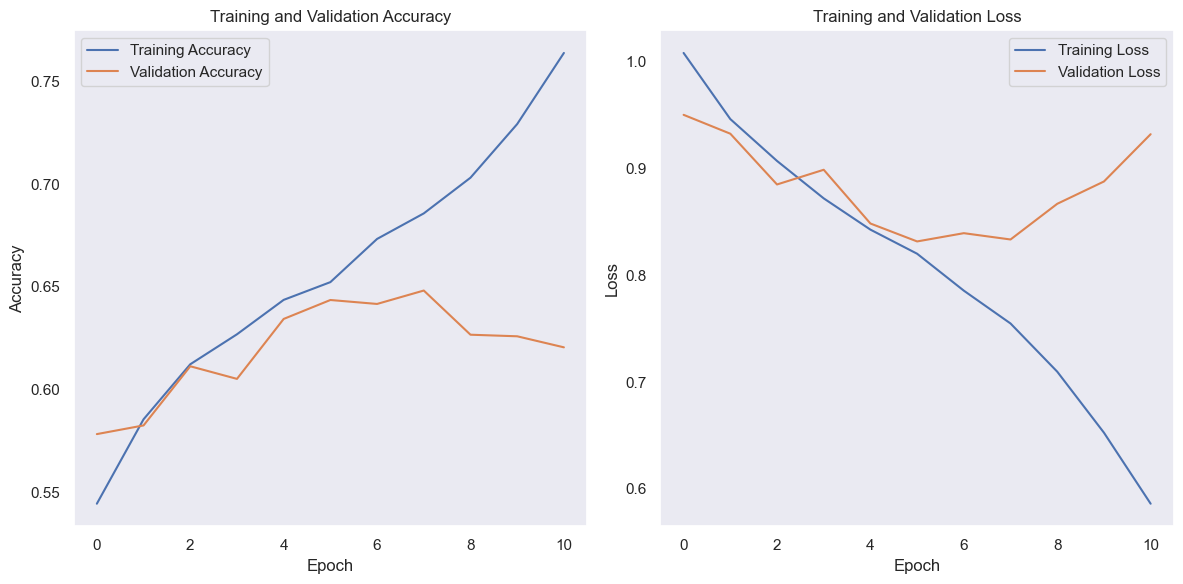

In [46]:
plot_epochs(model.history)

In [47]:
test_model = keras.models.load_model("models/base_model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

82/82 [==============================] - 9s 101ms/step - loss: 0.8547 - accuracy: 0.6429
Test accuracy: 0.643


82/82 [==============================] - 9s 105ms/step


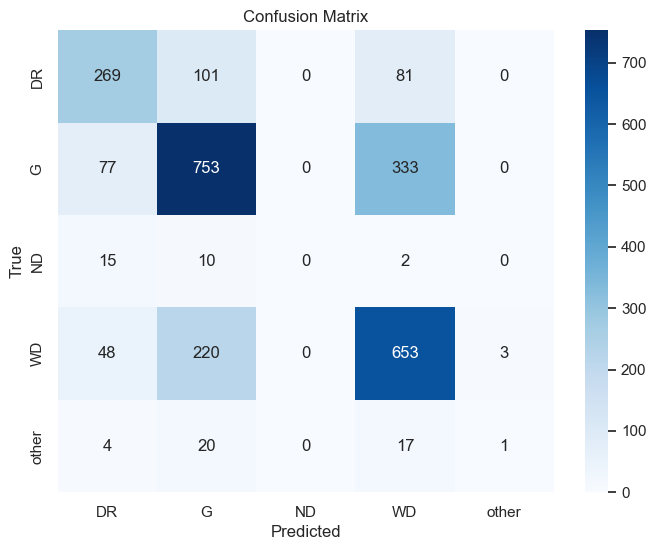

In [48]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# Data augmentation

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation((-0.5, 0.5), seed=13),
        layers.RandomContrast(0.5, seed=13),
        layers.RandomFlip("horizontal"),
    ]
)

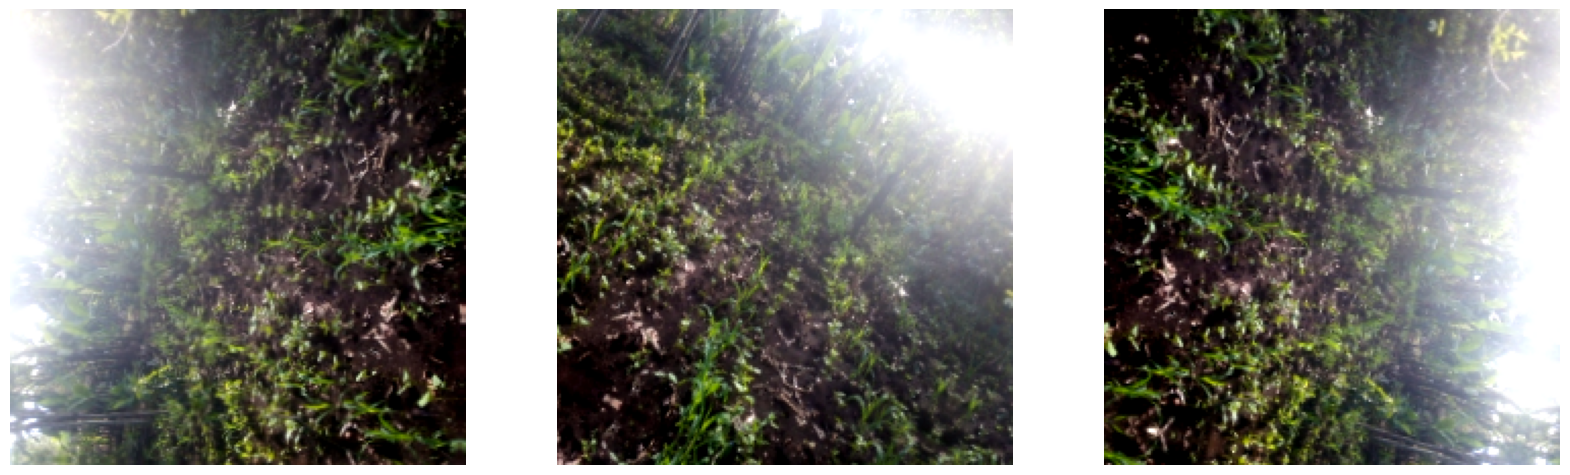

In [52]:
plt.figure(figsize=(20, 10))
for images, labels in train_dataset.take(1):
    for i in range(3):
        aug = data_augmentation(images)
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(aug[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()

In [89]:
inputs = keras.Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 109, 109, 32)      4640      
                                                          

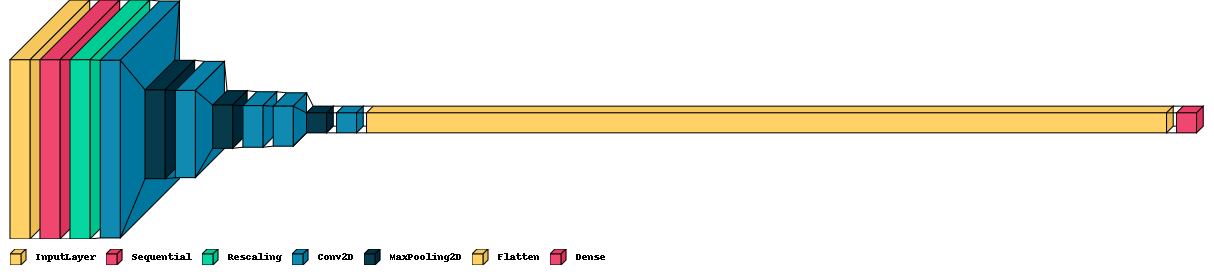

In [90]:
visualkeras.layered_view(model, legend=True, scale_xy=0.8, max_z=800)

In [91]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.00009),
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/augmented_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8),
    tensorboard_callback,
]

In [92]:
history = model.fit(
    train_dataset, epochs=500, validation_data=val_dataset, callbacks=callbacks
)

Epoch 1/500
652/652 [==============================] - 93s 139ms/step - loss: 1.1054 - accuracy: 0.4600 - val_loss: 1.0368 - val_accuracy: 0.5163
Epoch 2/500
652/652 [==============================] - 90s 136ms/step - loss: 1.0354 - accuracy: 0.5147 - val_loss: 1.0337 - val_accuracy: 0.5201
Epoch 3/500
652/652 [==============================] - 89s 135ms/step - loss: 1.0110 - accuracy: 0.5351 - val_loss: 0.9956 - val_accuracy: 0.5489
Epoch 4/500
652/652 [==============================] - 85s 128ms/step - loss: 1.0019 - accuracy: 0.5486 - val_loss: 1.0151 - val_accuracy: 0.5247
Epoch 5/500
652/652 [==============================] - 85s 128ms/step - loss: 0.9925 - accuracy: 0.5489 - val_loss: 0.9777 - val_accuracy: 0.5731
Epoch 6/500
652/652 [==============================] - 85s 129ms/step - loss: 0.9850 - accuracy: 0.5588 - val_loss: 0.9724 - val_accuracy: 0.5685
Epoch 7/500
652/652 [==============================] - 87s 131ms/step - loss: 0.9763 - accuracy: 0.5620 - val_loss: 0.9671 -

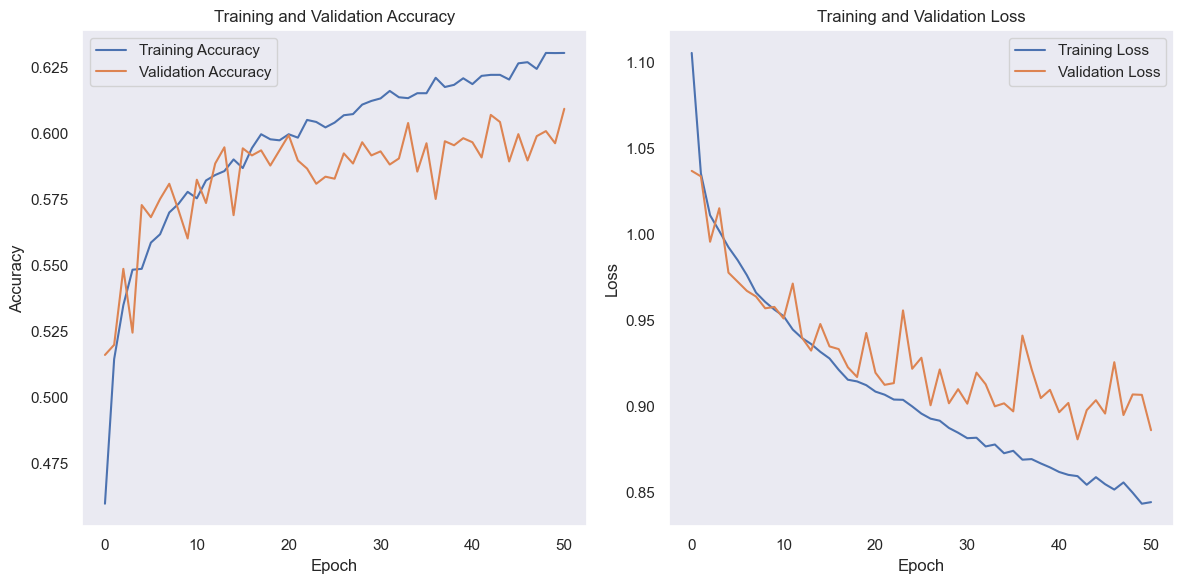

In [93]:
plot_epochs(model.history)

In [94]:
test_model = keras.models.load_model("models/augmented_model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

82/82 [==============================] - 11s 124ms/step - loss: 0.8931 - accuracy: 0.6110
Test accuracy: 0.611


82/82 [==============================] - 12s 130ms/step


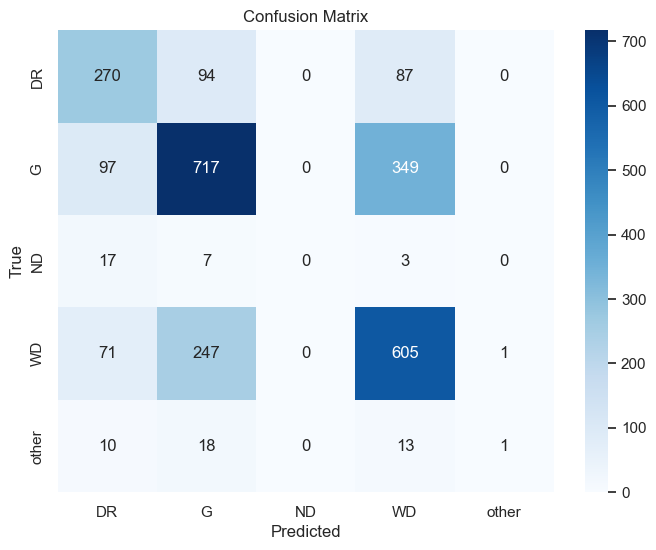

In [95]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# Dropout

In [37]:
height, width = 224, 224
batch_size = 128

train_dataset, val_dataset, test_dataset = dataset_from_directory(
    height, width, batch_size
)

Found 20854 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.


In [70]:
def thresholded_softmax(x, threshold=0.4):
    max_prob = tf.reduce_max(x, axis=-1, keepdims=True)
    mask = tf.math.greater_equal(max_prob, threshold)

    return tf.where(
        mask, x, tf.nn.softmax(tf.constant([0.2, 0.2, 0.3, 0.2, 0.1], dtype=tf.float32))
    )

In [93]:
l2_reg = keras.regularizers.l2(0.003)
initializer = keras.initializers.HeNormal()

inputs = keras.Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)
x = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=initializer,
)(x)
x = layers.Dropout(0.3)(x)
x = layers.Flatten()(x)
x = layers.Dense(5, activation="softmax")(x)
outputs = layers.Lambda(thresholded_softmax)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_65 (Conv2D)          (None, 220, 220, 16)      2320      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                          

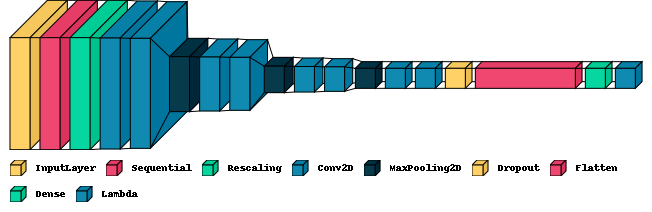

In [94]:
visualkeras.layered_view(
    model, legend=True, scale_xy=0.5, scale_z=0.01, max_z=100)

In [95]:
def scheduler(epoch, lr):
    if epoch <= 30:
        return 0.001
    elif epoch <= 60:
        return 0.0003
    else:
        return 0.00009

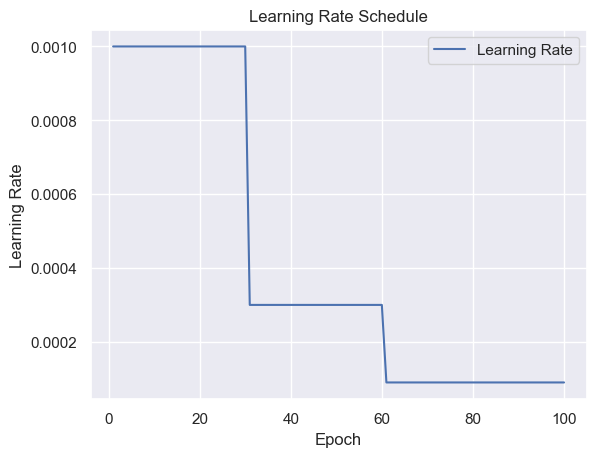

In [96]:
initial_lr = -1

# Define the number of epochs
num_epochs = 100

# Calculate the learning rates for each epoch using the scheduler function
learning_rates = []

for epoch in range(1, num_epochs + 1):
    new_lr = scheduler(epoch, initial_lr)
    learning_rates.append(new_lr)
    initial_lr = new_lr

# Plotting the learning rates
plt.plot(range(1, num_epochs + 1), learning_rates, label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

In [97]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/augmented_model_dropout.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20),
    tensorboard_callback,
    keras.callbacks.LearningRateScheduler(scheduler),
]

In [ ]:
history = model.fit(
    train_dataset, epochs=500, validation_data=val_dataset, callbacks=callbacks
)

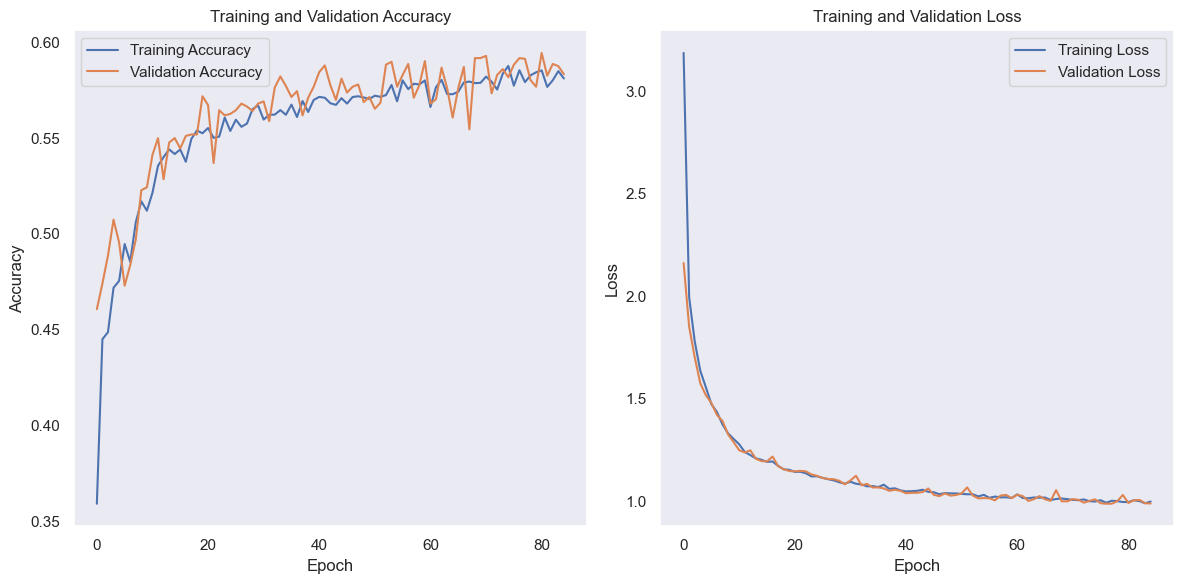

In [75]:
plot_epochs(model.history)

In [76]:
test_model = keras.models.load_model("models/augmented_model_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

11/11 [==============================] - 7s 613ms/step - loss: 0.9903 - accuracy: 0.5915
Test accuracy: 0.591


11/11 [==============================] - 8s 685ms/step


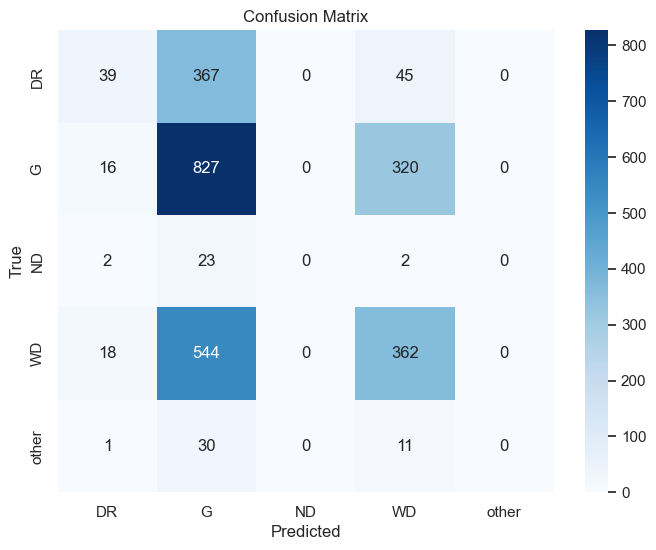

In [45]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# Regularization

In [141]:
def scheduler(epoch, lr):
    return 0.001

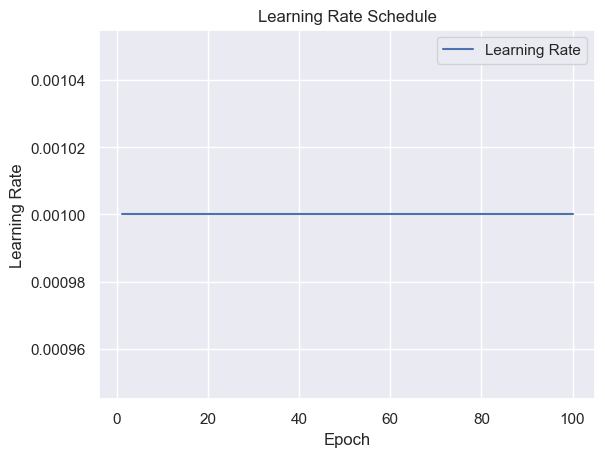

In [131]:
initial_lr = -1

# Define the number of epochs
num_epochs = 100

# Calculate the learning rates for each epoch using the scheduler function
learning_rates = []

for epoch in range(1, num_epochs + 1):
    new_lr = scheduler(epoch, initial_lr)
    learning_rates.append(new_lr)
    initial_lr = new_lr

# Plotting the learning rates
plt.plot(range(1, num_epochs + 1), learning_rates, label="Learning Rate")
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.legend()
plt.show()

In [183]:
l2_reg = keras.regularizers.l2(0.01)

inputs = keras.Input(shape=(height, width, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=13),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=1313),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=3131),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=313131),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=256,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=31),
)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_39 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_370 (Conv2D)         (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_134 (MaxPooli  (None, 111, 111, 16)     0         
 ng2D)                                                           
                                                                 
 conv2d_371 (Conv2D)         (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_135 (MaxPooli  (None, 54, 54, 32)       0         
 ng2D)                                                    

In [148]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/augmented_model_dropout.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12),
    tensorboard_callback,
    keras.callbacks.LearningRateScheduler(scheduler),
]

In [149]:
history = model.fit(
    train_dataset, epochs=500, validation_data=val_dataset, callbacks=callbacks
)

Epoch 1/500


82/82 [==============================] - 76s 825ms/step - loss: 6.9903 - accuracy: 0.4550 - val_loss: 4.3641 - val_accuracy: 0.4864 - lr: 0.0010
Epoch 2/500
82/82 [==============================] - 72s 792ms/step - loss: 3.5413 - accuracy: 0.5160 - val_loss: 3.0390 - val_accuracy: 0.5236 - lr: 0.0010
Epoch 3/500
82/82 [==============================] - 71s 796ms/step - loss: 2.6416 - accuracy: 0.5480 - val_loss: 2.4019 - val_accuracy: 0.5412 - lr: 0.0010
Epoch 4/500
82/82 [==============================] - 71s 787ms/step - loss: 2.1611 - accuracy: 0.5699 - val_loss: 1.9752 - val_accuracy: 0.5804 - lr: 0.0010
Epoch 5/500
82/82 [==============================] - 70s 781ms/step - loss: 1.8687 - accuracy: 0.5811 - val_loss: 1.7462 - val_accuracy: 0.5838 - lr: 0.0010
Epoch 6/500
82/82 [==============================] - 70s 779ms/step - loss: 1.6637 - accuracy: 0.5883 - val_loss: 1.6033 - val_accuracy: 0.5830 - lr: 0.0010
Epoch 7/500
82/82 [==============================] - 72s 802ms/step - 

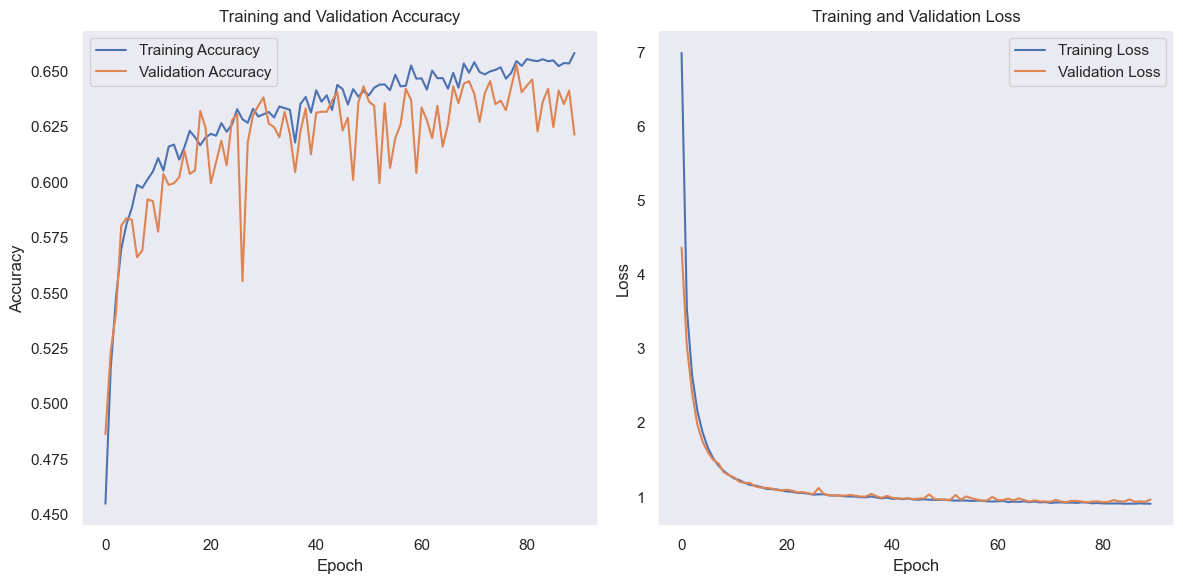

In [150]:
plot_epochs(model.history)

In [151]:
test_model = keras.models.load_model("models/augmented_model_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

11/11 [==============================] - 7s 638ms/step - loss: 0.9417 - accuracy: 0.6509
Test accuracy: 0.651


11/11 [==============================] - 7s 636ms/step


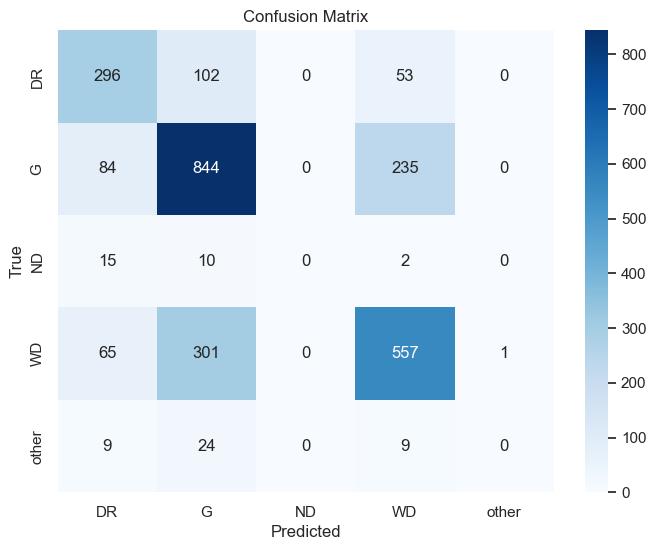

In [152]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# Assign different weights to different classes

In [65]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(true_labels), y=true_labels
)
class_weight_dict = dict(zip(train_dataset.class_names, class_weights))
for key in class_weight_dict.keys():
    class_weight_dict[key] = np.sqrt(class_weight_dict[key])
class_weight_dict

{'DR': 1.075219773337344,
 'G': 0.6695694899005442,
 'ND': 4.394440932713866,
 'WD': 0.7511895328648518,
 'other': 3.523391223563701}

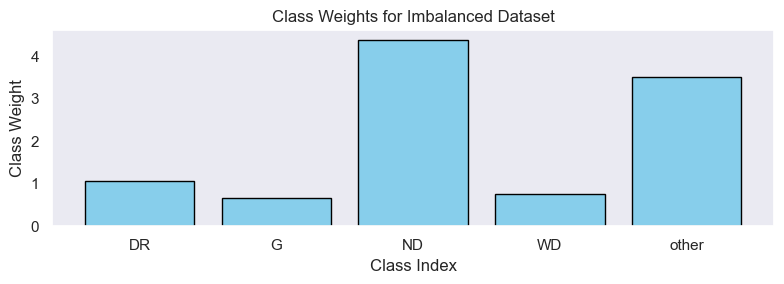

In [66]:
plt.figure(figsize=(8, 3))
plt.bar(
    class_weight_dict.keys(),
    class_weight_dict.values(),
    color="skyblue",
    edgecolor="black",
)
plt.xlabel("Class Index")
plt.ylabel("Class Weight")
plt.title("Class Weights for Imbalanced Dataset")
plt.xticks(list(class_weight_dict.keys()))
plt.tight_layout()
plt.show()

In [87]:
class_weight_dict = dict(enumerate(class_weights))
for key in class_weight_dict.keys():
    class_weight_dict[key] = class_weight_dict[key] ** 0.6
class_weight_dict

{0: 1.0909295131457761,
 1: 0.6179520641633587,
 2: 5.908596836382384,
 3: 0.7094134748668844,
 4: 4.532658940713281}

In [88]:
l2_reg = keras.regularizers.l2(0.015)

inputs = keras.Input(shape=(height, width, 3))
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(
    filters=16,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=13),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=1313),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=3131),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=313131),
)(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(
    filters=256,
    kernel_size=3,
    activation="relu",
    kernel_regularizer=l2_reg,
    kernel_initializer=keras.initializers.HeNormal(seed=31),
)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_16 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_203 (Conv2D)         (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_204 (Conv2D)         (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_65 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                     

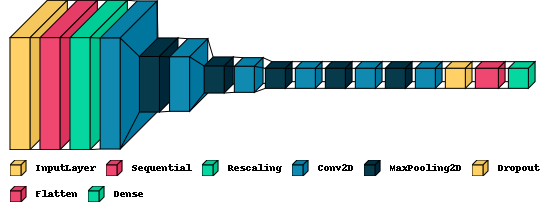

In [116]:
visualkeras.layered_view(
    model, legend=True, scale_xy=0.5, scale_z=0.01, max_z=100)

In [89]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/augmented_model_weights.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12),
    tensorboard_callback,
]

In [90]:
history = model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weight_dict,
)

Epoch 1/500
652/652 [==============================] - 68s 103ms/step - loss: 3.4868 - accuracy: 0.4216 - val_loss: 1.6093 - val_accuracy: 0.4457
Epoch 2/500
652/652 [==============================] - 68s 102ms/step - loss: 1.4230 - accuracy: 0.4434 - val_loss: 1.3325 - val_accuracy: 0.4549
Epoch 3/500
652/652 [==============================] - 68s 102ms/step - loss: 1.2718 - accuracy: 0.4594 - val_loss: 1.2425 - val_accuracy: 0.4776
Epoch 4/500
652/652 [==============================] - 67s 102ms/step - loss: 1.2123 - accuracy: 0.4808 - val_loss: 1.1839 - val_accuracy: 0.4983
Epoch 5/500
652/652 [==============================] - 67s 102ms/step - loss: 1.1730 - accuracy: 0.5094 - val_loss: 1.1516 - val_accuracy: 0.5228
Epoch 6/500
652/652 [==============================] - 67s 102ms/step - loss: 1.1505 - accuracy: 0.5223 - val_loss: 1.1528 - val_accuracy: 0.5313
Epoch 7/500
652/652 [==============================] - 67s 102ms/step - loss: 1.1348 - accuracy: 0.5352 - val_loss: 1.1096 -

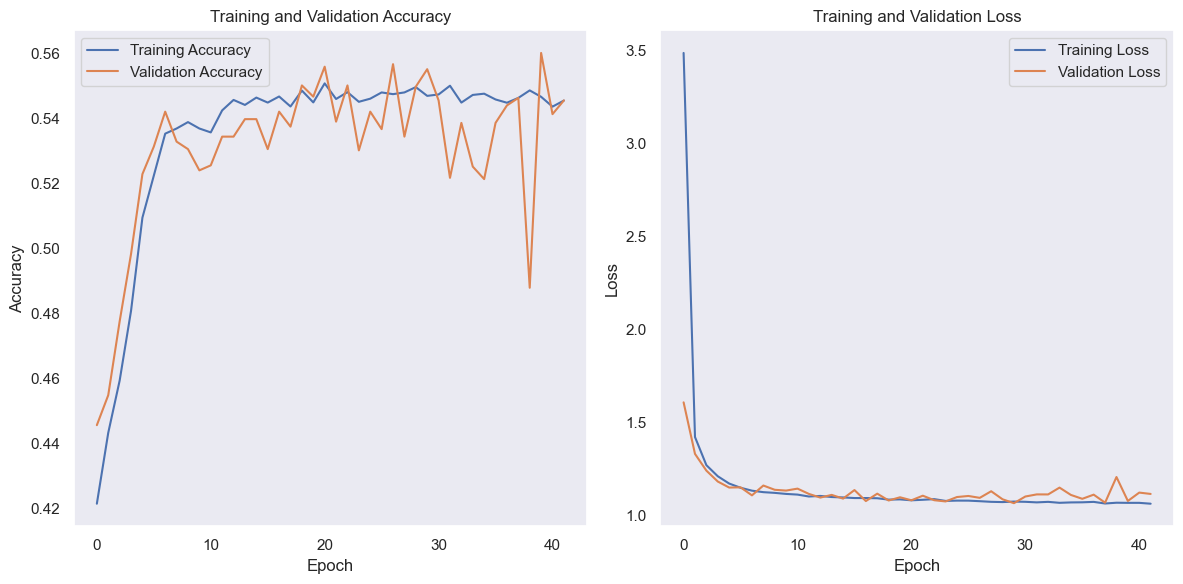

In [91]:
plot_epochs(history)

In [92]:
test_model = keras.models.load_model("models/augmented_model_weights.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

82/82 [==============================] - 7s 86ms/step - loss: 1.0873 - accuracy: 0.5412
Test accuracy: 0.541


82/82 [==============================] - 8s 89ms/step


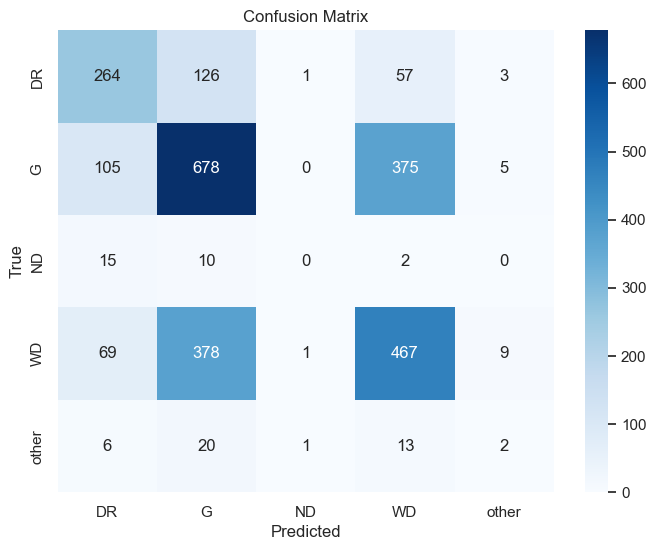

In [93]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# Oversampling + Undersampling

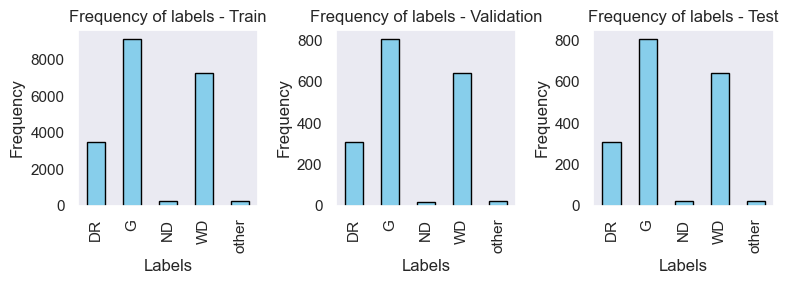

In [112]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

train["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[0]
)
axes[0].set_title("Frequency of labels - Train")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Frequency")

val["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[1]
)
axes[1].set_title("Frequency of labels - Validation")
axes[1].set_xlabel("Labels")
axes[1].set_ylabel("Frequency")

test["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[2]
)
axes[2].set_title("Frequency of labels - Test")
axes[2].set_xlabel("Labels")
axes[2].set_ylabel("Frequency")

plt.tight_layout()

plt.show()

In [113]:
DR_freq = train[train["target"] == "DR"].shape[0]
print(f"DR label has {DR_freq} samples")

DR label has 3509 samples


ND and other classes will have the same number of data as DR.

G and WD classes will be reduced to 2/3 of their number of data.

In [114]:
sampled_df = train[train["target"] == "DR"].copy(deep=True)

for c in ["ND", "other"]:
    class_df = train[train["target"] == c].copy(deep=True)
    sampled_class = class_df.sample(
        DR_freq - class_df.shape[0], random_state=13, ignore_index=False, replace=True
    )
    sampled_df = pd.concat([sampled_df, class_df, sampled_class], axis=0)

for c in ["G", "WD"]:
    class_df = train[train["target"] == c].copy(deep=True)
    sampled_class = class_df.sample(
        class_df.shape[0] - int(class_df.shape[0] / 3),
        random_state=13,
        ignore_index=False,
        replace=False,
    )
    sampled_df = pd.concat([sampled_df, sampled_class], axis=0)

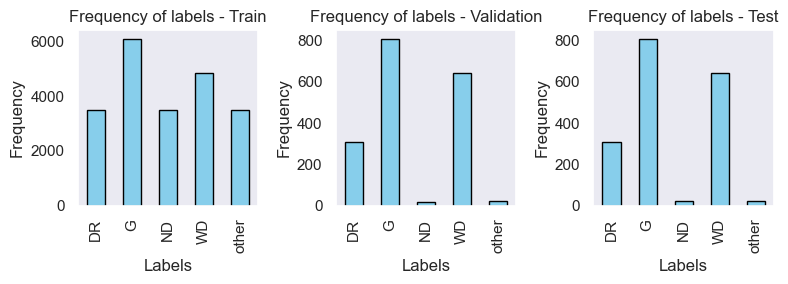

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(8, 3))

sampled_df["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[0]
)
axes[0].set_title("Frequency of labels - Train")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Frequency")

val["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[1]
)
axes[1].set_title("Frequency of labels - Validation")
axes[1].set_xlabel("Labels")
axes[1].set_ylabel("Frequency")

test["target"].value_counts().sort_index().plot(
    kind="bar", color="skyblue", edgecolor="black", ax=axes[2]
)
axes[2].set_title("Frequency of labels - Test")
axes[2].set_xlabel("Labels")
axes[2].set_ylabel("Frequency")

plt.tight_layout()

plt.show()

In [103]:
for _, (_, filename, target) in sampled_df.iterrows():
    time_now = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S-%f")
    destination = f"organized-data/oversampled_train/{target}/{time_now}_{filename}"
    source = f"data/labeled/{filename}"
    shutil.copy(source, destination)

In [116]:
height, width = 224, 224
batch_size = 32

train_dataset, val_dataset, test_dataset = dataset_from_directory(
    height, width, batch_size, oversample=True
)

Found 21500 files belonging to 5 classes.
Found 1806 files belonging to 5 classes.
Found 1805 files belonging to 5 classes.


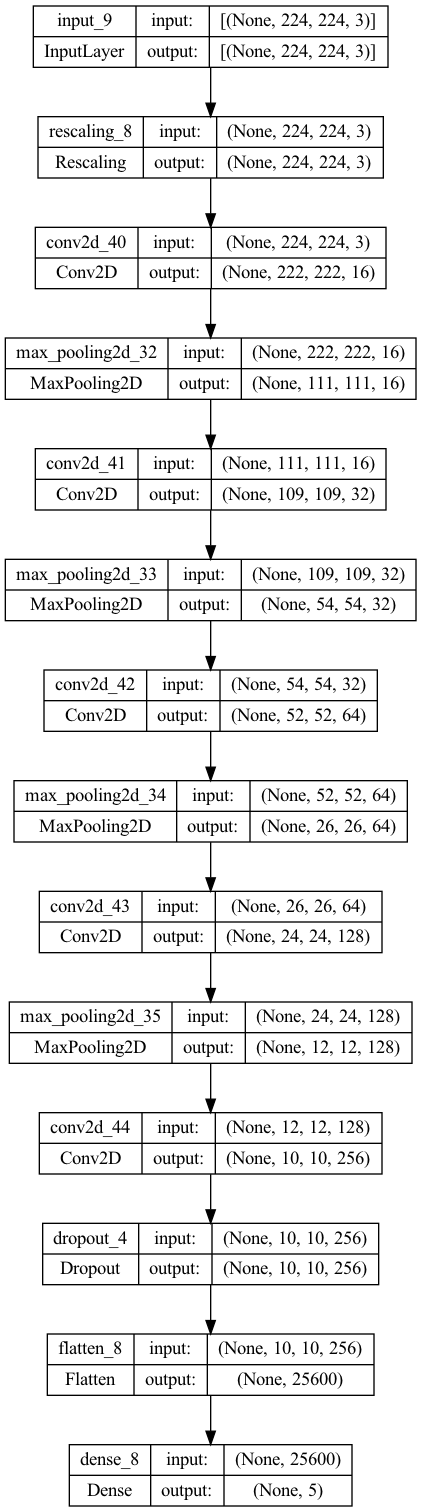

In [117]:
inputs = keras.Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
plot_model(
    model,
    to_file="models/oversample_undersample_model.png",
    show_shapes=True,
    show_layer_names=True,
)

In [118]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.legacy.Adam(),
    metrics=["accuracy"],
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/oversample_undersample_model.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
]

In [119]:
history = model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/500


672/672 [==============================] - 58s 85ms/step - loss: 1.4739 - accuracy: 0.3164 - val_loss: 1.3060 - val_accuracy: 0.4502
Epoch 2/500
672/672 [==============================] - 58s 86ms/step - loss: 1.3238 - accuracy: 0.4164 - val_loss: 1.2044 - val_accuracy: 0.4972
Epoch 3/500
672/672 [==============================] - 58s 86ms/step - loss: 1.1006 - accuracy: 0.5394 - val_loss: 1.1541 - val_accuracy: 0.5105
Epoch 4/500
672/672 [==============================] - 58s 86ms/step - loss: 0.8361 - accuracy: 0.6578 - val_loss: 1.0524 - val_accuracy: 0.5570
Epoch 5/500
672/672 [==============================] - 58s 85ms/step - loss: 0.6462 - accuracy: 0.7305 - val_loss: 1.1407 - val_accuracy: 0.5532
Epoch 6/500
672/672 [==============================] - 58s 85ms/step - loss: 0.5450 - accuracy: 0.7712 - val_loss: 1.1242 - val_accuracy: 0.5808
Epoch 7/500
672/672 [==============================] - 58s 86ms/step - loss: 0.4900 - accuracy: 0.7945 - val_loss: 1.1418 - val_accuracy: 0.57

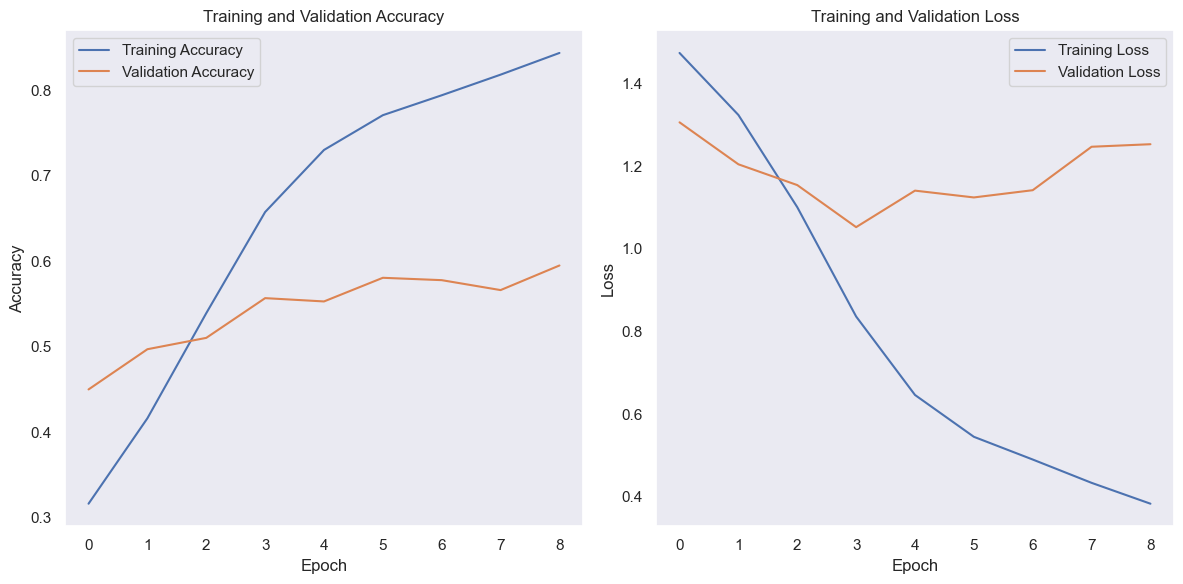

In [120]:
plot_epochs(history)

In [122]:
test_model = keras.models.load_model(
    "models/oversample_undersample_model.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

57/57 [==============================] - 5s 70ms/step - loss: 1.0108 - accuracy: 0.5850
Test accuracy: 0.585


204/204 [==============================] - 19s 91ms/step


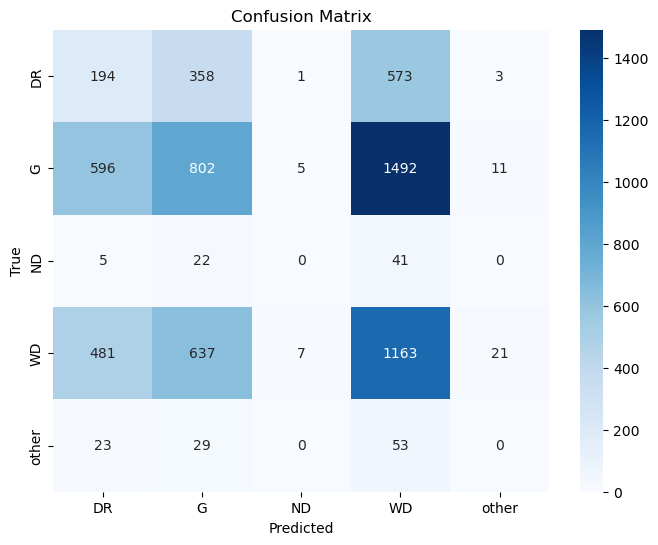

In [ ]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# Residual Connections

In [164]:
height, width = 224, 224
batch_size = 128

train_dataset, val_dataset, test_dataset = dataset_from_directory(
    height, width, batch_size
)

Found 20854 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.
Found 2607 files belonging to 5 classes.


In [184]:
inputs = keras.Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)


def residual_block(x, filters, seed, pooling=False):
    residual = x
    x = layers.Conv2D(
        filters,
        3,
        activation=None,
        padding="same",
        kernel_initializer=keras.initializers.HeNormal(seed=seed),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # x = layers.Conv2D(
    #     filters,
    #     2,
    #     activation=None,
    #     padding="same",
    #     kernel_regularizer=l2_reg,
    # )(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)

    if pooling:
        x = layers.MaxPooling2D(2, padding="same")(x)
        residual = layers.Conv2D(
            filters,
            1,
            strides=2,
        )(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(
            filters,
            1,
        )(residual)
    x = layers.add([x, residual])
    return x


x = residual_block(x, filters=16, seed=13, pooling=True)
x = layers.Dropout(0.1)(x)
x = residual_block(x, filters=32, seed=1313, pooling=True)
x = layers.Dropout(0.1)(x)
x = residual_block(x, filters=64, seed=313131, pooling=True)
x = layers.Dropout(0.1)(x)
x = residual_block(x, filters=128, seed=3131, pooling=True)
x = layers.Dropout(0.1)(x)
x = residual_block(x, filters=128, seed=3131, pooling=True)
x = layers.Dropout(0.1)(x)
x = residual_block(x, filters=256, seed=31, pooling=False)
x = layers.Dropout(0.5)(x)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(5, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_57 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_57[0][0]']               
                                                                                                  
 rescaling_55 (Rescaling)       (None, 224, 224, 3)  0           ['sequential[51][0]']            
                                                                                                  
 conv2d_660 (Conv2D)            (None, 224, 224, 16  448         ['rescaling_55[0][0]']    

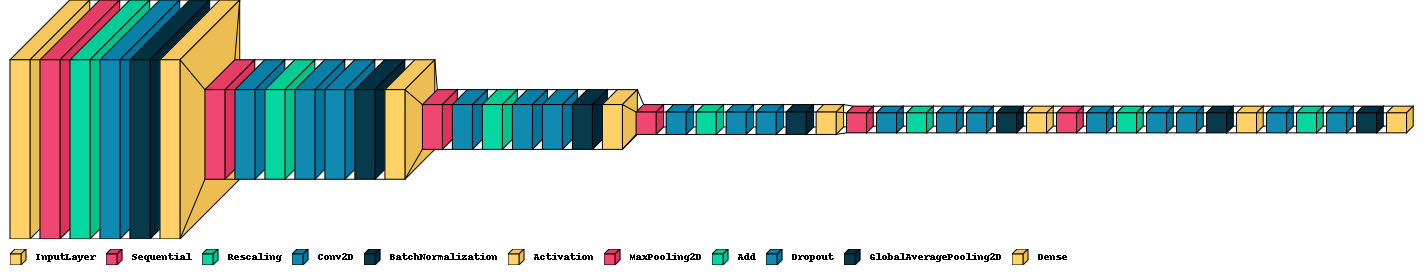

In [185]:
visualkeras.layered_view(
    model, legend=True, scale_xy=0.8, scale_z=0.01, max_z=100)

In [187]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.003),
    metrics=["accuracy"],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/residual_model_regularized.keras",
        save_best_only=True,
        monitor="val_loss",
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12),
    tensorboard_callback,
]

In [188]:
history = model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=callbacks,
)

Epoch 1/500
163/163 [==============================] - 83s 473ms/step - loss: 1.2211 - accuracy: 0.4734 - val_loss: 1.1556 - val_accuracy: 0.4319
Epoch 2/500
163/163 [==============================] - 76s 443ms/step - loss: 1.0342 - accuracy: 0.5282 - val_loss: 1.2630 - val_accuracy: 0.3813
Epoch 3/500
163/163 [==============================] - 76s 444ms/step - loss: 1.0153 - accuracy: 0.5434 - val_loss: 1.3007 - val_accuracy: 0.3951
Epoch 4/500
163/163 [==============================] - 73s 429ms/step - loss: 0.9969 - accuracy: 0.5545 - val_loss: 1.4450 - val_accuracy: 0.4150
Epoch 5/500
163/163 [==============================] - 77s 446ms/step - loss: 0.9818 - accuracy: 0.5638 - val_loss: 1.1024 - val_accuracy: 0.4879
Epoch 6/500
163/163 [==============================] - 72s 424ms/step - loss: 0.9695 - accuracy: 0.5691 - val_loss: 1.1435 - val_accuracy: 0.4852
Epoch 7/500
163/163 [==============================] - 73s 427ms/step - loss: 0.9655 - accuracy: 0.5707 - val_loss: 1.1651 -

# Hyperparameter Tuning Residual NN

In [173]:
class LRFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, logs):
        lr = keras.backend.get_value(self.model.optimizer.lr)
        loss = logs["loss"]

        self.lrs.append(lr)
        self.losses.append(loss)

        if np.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        keras.backend.set_value(self.model.optimizer.lr, lr * self.lr_mult)

    def find(
        self, train_dataset, data_size, start_lr, end_lr, batch_size=128, epochs=1
    ):
        num_batches = epochs * data_size / batch_size

        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)
        self.model.save_weights("tmp.h5")
        original_lr = keras.backend.get_value(self.model.optimizer.lr)
        keras.backend.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(
            on_batch_end=lambda batch, logs: self.on_batch_end(logs)
        )

        self.model.fit(
            train_dataset, batch_size=batch_size, epochs=epochs, callbacks=[callback]
        )

        self.model.load_weights("tmp.h5")

        keras.backend.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(
            self.lrs[n_skip_beginning:-n_skip_end],
            self.losses[n_skip_beginning:-n_skip_end],
        )
        plt.xscale("log")

In [174]:
lrfinder = LRFinder(model)
lrfinder.find(
    train_dataset, train.shape[0], start_lr=0.00001, end_lr=2, batch_size=128, epochs=5
)

Epoch 1/5
163/163 [==============================] - 72s 408ms/step - loss: 1.1435 - accuracy: 0.4774
Epoch 2/5
163/163 [==============================] - 69s 400ms/step - loss: 1.0812 - accuracy: 0.4961
Epoch 3/5
163/163 [==============================] - 68s 393ms/step - loss: 1.0811 - accuracy: 0.5009
Epoch 4/5
163/163 [==============================] - 24s 124ms/step - loss: 171.3069 - accuracy: 0.4484


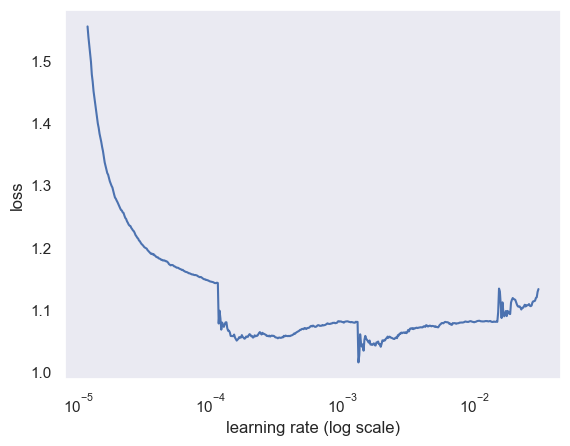

In [175]:
lrfinder.plot_loss()

In [ ]:
history = model.fit(
    train_dataset,
    epochs=500,
    validation_data=val_dataset,
    callbacks=callbacks,
)

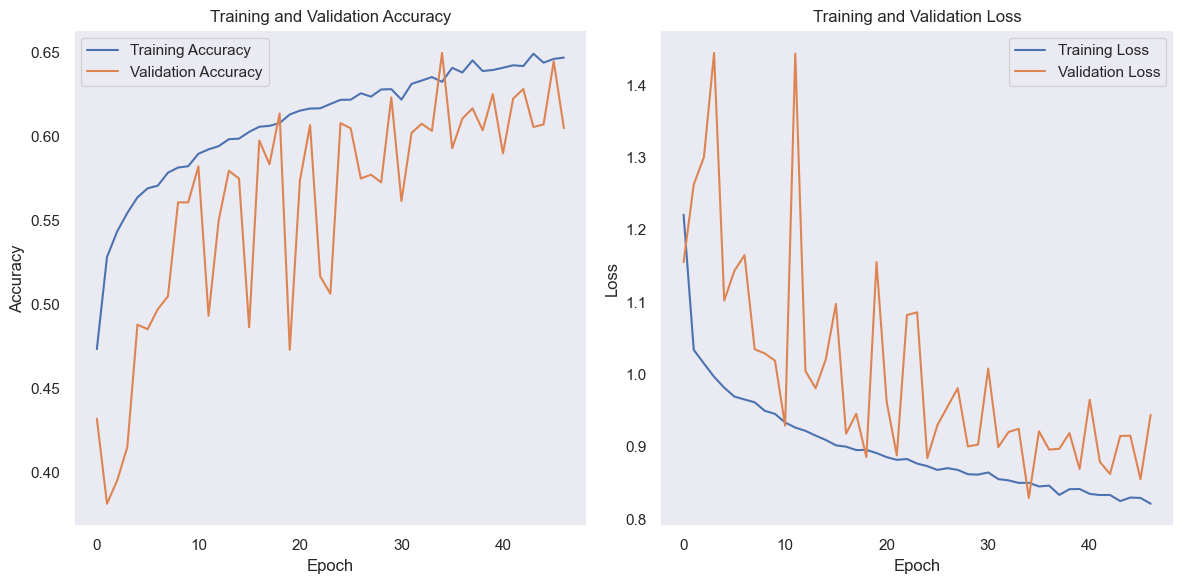

In [189]:
plot_epochs(history)

In [190]:
test_model = keras.models.load_model("models/residual_model_regularized.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

21/21 [==============================] - 8s 339ms/step - loss: 0.8616 - accuracy: 0.6475
Test accuracy: 0.647


21/21 [==============================] - 8s 356ms/step


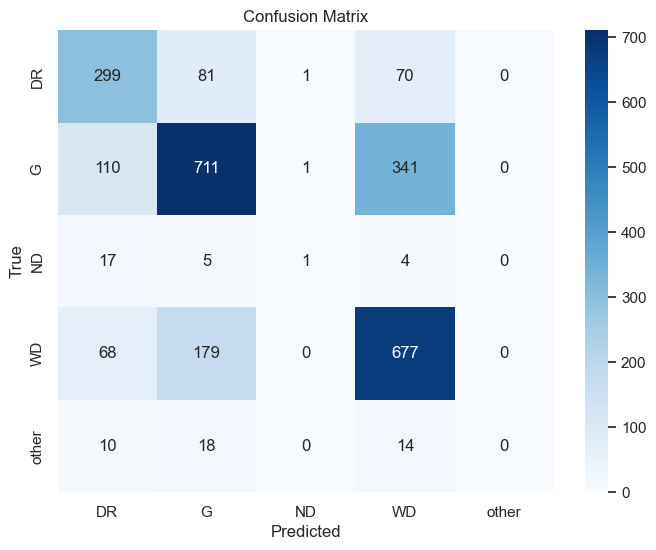

In [191]:
plot_confusion_matrix(test_model, test_dataset, true_labels)

# ViT

Loading the dataset using the load_dataset function from the Hugging Face datasets library. 
The dataset is assumed to be organized in the ImageFolder format, where images are stored in folders representing their classes.

In [34]:
train_dataset = load_dataset("imagefolder", data_dir="organized-data/dataset/")

Resolving data files: 100%|██████████| 24069/24069 [00:00<00:00, 976067.44it/s]


A pre-trained ViT model checkpoint (google/vit-base-patch16-224) is used.

In [35]:
checkpoint = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

The dataset is split into training, testing, and validation sets using the train_test_split function.

In [36]:
train_dataset = load_dataset("imagefolder", data_dir="organized-data/train/")
test_dataset = load_dataset("imagefolder", data_dir="organized-data/test/")
val_dataset = load_dataset("imagefolder", data_dir="organized-data/validation/")

dataset = DatasetDict(
    {
        "train": train_dataset["train"],
        "test": test_dataset["train"],
        "valid": val_dataset["train"],
    }
)

Resolving data files: 100%|██████████| 2607/2607 [00:00<00:00, 845280.65it/s]


In [37]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label)
print(label2id)

{0: 'DR', 1: 'G', 2: 'ND', 3: 'WD', 4: 'other'}
{'DR': 0, 'G': 1, 'ND': 2, 'WD': 3, 'other': 4}


Data augmentation is performed on the training and validation sets using TensorFlow's Sequential API. 
For training data, augmentation techniques like resizing, rescaling, flipping, rotation, and zooming are applied to increase the diversity of training samples and improve model generalization. 
For validation data, only resizing and rescaling are applied.

In [38]:
train_data_augmentation = keras.Sequential(
    [
        layers.Resizing(
            image_processor.size["height"], image_processor.size["width"]),
        layers.Rescaling(scale=image_processor.rescale_factor),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        layers.Normalization(
            mean=image_processor.image_mean, variance=image_processor.image_std
        ),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(
            image_processor.size["height"], image_processor.size["width"]
        ),
        layers.Rescaling(scale=image_processor.rescale_factor),
        layers.Normalization(
            mean=image_processor.image_mean, variance=image_processor.image_std
        ),
    ],
    name="val_data_augmentation",
)

In [39]:
def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB")))
        for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [
        tf.transpose(tf.squeeze(image)) for image in images
    ]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB")))
        for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [
        tf.transpose(tf.squeeze(image)) for image in images
    ]
    return example_batch


dataset["train"].set_transform(preprocess_train)
dataset["valid"].set_transform(preprocess_val)

In [40]:
batch_size = 32
num_epochs = 4

In [41]:
model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFViTForImageClassification: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing TFViTForImageClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.
Some weights of TFViTForImageClassification were not initialized from the model checkpoint are newly initialize

In [48]:
sz = len(model.vit.encoder.layer)

for i in range(sz - 1):
    model.vit.encoder.layer[i].trainable = False

In [49]:
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = dataset["train"].to_tf_dataset(
    columns="pixel_values",
    label_cols="label",
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_eval_dataset = dataset["valid"].to_tf_dataset(
    columns="pixel_values",
    label_cols="label",
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

In [50]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=7e-5),
    loss=loss,
    metrics=["accuracy"],
)

In [51]:
accuracy = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [52]:
class ModelCheckpoint(keras.callbacks.Callback):
    def __init__(self, freq):
        super().__init__()
        self.freq = freq

    def on_epoch_end(self, epoch, logs=None):
        if self.freq > 0 and epoch % self.freq == 0:
            self.model.save(f"vit-tf/model-{epoch}")

In [53]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_eval_dataset
)
save_callback = (ModelCheckpoint(1),)
callbacks = [metric_callback, save_callback]

In [ ]:
model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=num_epochs,
    callbacks=callbacks,
)

# Evaluation

In [37]:
to_test = pd.read_csv("data/unlabeled.csv")
to_test

ID                                      filename
0     ID_QW9GQM  03428805a0d7d269b422dbfafb3f86cb394a0491.jpg
1     ID_G9VPQ9  5dcf4f5d82708496ad7c3227ccbc8af5058aa227.jpg
2     ID_QIMIEM  4e835aa40e4aafa24db13cba4182094eb9e5eb79.jpg
3     ID_TSINUQ  1e0dbb8669385be73a480ce108d12bdc4354f120.jpg
4     ID_I7OOHH  3d05e31502f9f00ce25770666c73af5f323a8b3a.jpg
...         ...                                           ...
8658  ID_JZJP19  8b58a11023be5530af0fd1800b2c53c36f50605f.jpg
8659  ID_137G9B  2d3c4c70b893bf32c33919e5c1703b816b95a6d9.jpg
8660  ID_F7R60Y  49d9c6cadb9a424fc31aff1d6732023235e6ceb7.jpg
8661  ID_76JGLU  618f93ddbb02e2abf4b97ac458b2c2e727c2e0a4.jpg
8662  ID_3QSZHE  558440cbf388be936c724c36684aa09d119cfc34.jpg

[8663 rows x 2 columns]

In [ ]:
loaded_images = []
image_ids = []
for row, (ID, path) in tqdm(to_test.iterrows(), total=to_test.shape[0]):
    img = keras.utils.load_img(f"data/unlabeled/{path}", target_size=(224, 224))
    img_array = keras.utils.img_to_array(img)
    img_array = keras.backend.expand_dims(img_array, 0)

    loaded_images.append(img_array)
    image_ids.append(ID)

In [ ]:
test_model = keras.models.load_model("vit-tf/model-1/")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

In [ ]:
class_labels = ["DR", "G", "ND", "WD", "other"]
submission_df = pd.DataFrame(0, columns=class_labels, index=to_test["ID"])

for i in tqdm(range(len(loaded_images))):
    predictions = test_model.predict(loaded_images[i], verbose=0)
    predicted_class_index = np.argmax(predictions)
    submission_df.loc[image_ids[i], class_labels[predicted_class_index]] = 1.0

submission_df.to_csv("submission.csv")
submission_df.describe()

100%|██████████| 8663/8663 [04:26<00:00, 32.47it/s]


DR            G           ND           WD   other
count  8663.000000  8663.000000  8663.000000  8663.000000  8663.0
mean      0.189773     0.454115     0.000923     0.355189     0.0
std       0.392144     0.497919     0.030376     0.478598     0.0
min       0.000000     0.000000     0.000000     0.000000     0.0
25%       0.000000     0.000000     0.000000     0.000000     0.0
50%       0.000000     0.000000     0.000000     0.000000     0.0
75%       0.000000     1.000000     0.000000     1.000000     0.0
max       1.000000     1.000000     1.000000     1.000000     0.0